In [495]:
# We are trying to create a viable solution for an existing business problem to provide better recommendatons to enhance the user experience andincrese
# user interaction by capturing user interest in a more efficient way.
# We have used a probabilistic approach called LDA(Linear Dirichlet Allocation) to identify hidden user interests and produce recommendations.
# We have performed a series of data generation steps , data transformation steps and  programming to model the process to our needs.
# we have tried giving the detailed description of all the steps but still it is bit messy :).
# The final implementation is at the end  where we can simply give a user id and get the recommendations.
# We have also handled the scenario for a new user(Cold Start) and provided the logic which we have followed.

In [496]:
import pandas as pd
import numpy as np
import random
import scipy
import math
import sklearn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [497]:
#Below code will create the reqired Click stream data as per the Approximations described below.

#Users - we are considering 10 users

#User sessions - We have considered  that a user can login in a range of 1 to 5.
#    This should follow a discrete distribution. Login -[1,2,3,4,5]  Prior Prob - [.3,.25,.2,.15,.1]

# Article ID -  we alrady have our articles. We are taking random sample without replacement from the available articles in such a way
#    that no article which was ever served to user will be available for sampling.

# Rank -  In every session 10 articles are being served to user, so each article will be assigned a rank from range 1 to 10 randomly following 
#    a discrete distribution with equal probabilities.

# Click - We are considering click distribution as a discrete distribution with equal probabilities. 
#     Click -["Yes","No"] Prior prob -[.5,.5]

# TimeSpent - we have considered this as a mixture of three distributions and selected the sample from this mixture model for all Articles.
#      Details are provided in code

# Date - Static dates were added to include efect of time 

In [8]:
# creating clickstream data
# I am estimating 10 users. ranging from id 1 to 10
# first of all create 6 entries for each visit category where each user can appear those many times

appear = [1,2,3,4,5]
appearProb = [.3,.25,.2,.15,.1]
appearEntries = list(np.random.choice(appear,6,p=appearProb))
#now when we have our visit categories , we will randomly select a category from this array  for every user to crate those many sessions
numVisits = random.sample(appearEntries,1)
Users = list(range(1,11))
UserVisitDict ={}
for u in Users:
    numVisits = random.sample(appearEntries,1)
    UserVisitDict[u] =numVisits[0]
# now we can generate random rank that the item will have from a given list of 1 to 10,this is a bit tricky as we want to generate a random but unrepeated rank
#from a list of 1 to 10
def getRank():
    retlist = random.sample(range(1,11),10)
    return retlist
# now we can select news articles randomly to place against the ranks
news_df =pd.read_csv("D:\\Recommendation engine\\news_articles.csv")
ArticleId = news_df.Article_Id
ArticleId =set(ArticleId)
# now we have our user and estimated visits , we can create the entries for them to fill remaing variables
from itertools import repeat
UserID =[]
VisitID =[]
rankList =[]
UserArticles=[]
DateList =[]

for k in UserVisitDict.keys():
    val = UserVisitDict[k]
    UArticleId = ArticleId.copy()
    tempArticles=[]
    for v in range(val):
        v1=v+1
        UserID.extend(repeat(k,10))
        VisitID.extend(repeat(v1,10))
        rankList.extend(getRank())
        dateVar =  str(str(v1)+"-03-2018")
        DateList.extend(repeat(dateVar,10))
        for i in range(10):
            
            articles = random.sample(UArticleId,1)[0]
            tempArticles.append(articles)
            
            UArticleId = list(set(UArticleId).difference(tempArticles))
        
        
    UserArticles.extend(tempArticles) 
# creating USer daatframe
UserDfGenerated = pd.DataFrame({"UserID":UserID,"SessionID":VisitID,"Rank":rankList,"Article_Id":UserArticles,"Date":DateList})
#Now i want to generate clicks for these articles. I am considering that upon being displayed to the user, each article has equal prob of being clicked or not
# prob of user clicking an article=.5
# prob of user not clicking an article=.5
# under these circumstances , we can then sample for click status from a discrete distribution having these probabiliies
distributionClick = np.random.choice(["Yes","No"],UserDfGenerated.shape[0],p=[.5,.5])        
UserDfGenerated["Click"] = distributionClick
# we now need to generate data for the time spent variable
# we think that there are three knid of users
# First- who just click and move away having mean time 40 secs and std Dev 20
# second - who click on an article , review the content for some time and go away if they do not like it  having mean of 80 seconds and std dev 10
# third - who click on an article, review it thoroughly and then move if they don't like it otherwise will stay with mean of 140 sec and std dev 20
# we will use the mixtre model to generate this data for our time spent column
import scipy.stats
myComps = (scipy.stats.norm(40,20),scipy.stats.norm(80,10),scipy.stats.norm(140,20))
priorProb=  [.3,.4,.3]# we are just considering this prob distribution

def genSample(size,myComps,priorProb):
    myData = np.empty(0)
    for comp,prior in zip(myComps,priorProb):
        newData = comp.rvs(int(size*prior))
        myData = np.append(myData,newData)
    return myData
timeSpenData = genSample(UserDfGenerated.shape[0],myComps,priorProb)

UserDfGenerated["TimeSpent"] = timeSpenData
UserDfGenerated["TimeSpent"] = UserDfGenerated["TimeSpent"].astype(int)   
# we have generated the timeSpent for the Articles which were not clicked, making them 0
UserDfGenerated.loc[UserDfGenerated["Click"]=="No","TimeSpent"]= 0   
UserDfGenerated.to_csv("D:\\Recommendation engine\\Users_generated.csv")
    
    


In [498]:
# Reading the data again

news_df =pd.read_csv("D:\\Recommendation engine\\news_articles.csv")
user_df =pd.read_csv("D:\\Recommendation engine\\Users_generated.csv")


# creating new fields for click 

# if clicked we give it weight 5 or 0

clickedMapping = {"Yes":5,"No":0}

user_df["actionStrength"] = user_df.Click.map(clickedMapping)


#Replacing missing values in timespent column by 0
user_df.TimeSpent.fillna(0,inplace=True)



In [500]:
#creating a category field for TimeSpent variable to better take the effect
user_df["timeEffect"] = pd.cut(user_df.TimeSpent,bins=[0,1,10,20,40,1000],include_lowest=True,labels=["Not Seen","Small","Moderate","Liked","Very much Liked"])


#Assigning weights for the timeSpent
TimeSpentMapping = {"Not Seen":0,"Small":.5,"Moderate":2,"Liked":3,"Very much Liked":4}
user_df["TimeWeight"] = user_df["timeEffect"].map(TimeSpentMapping)
user_df.head(2)



,UserID,SessionID,Article_Id,rankList,Click,TimeSpent,Date,actionStrength,timeEffect,TimeWeight
0,1,1,2413,6,No,0,01-03-2018,0,Not Seen,0.0
1,1,1,2882,7,No,0,01-03-2018,0,Not Seen,0.0


In [501]:
# find length of the News( number of words in it)
news_df["storylength"] = news_df["Content"].apply(lambda x: len(str(x).split(" ")))

# find average word length(to make more suitable clusters based on complexity of words)
def avgWordLength(sentence):
    words = sentence.split(" ")
    avgLength = round((sum(len(word) for word in words)/len(words)))
    return avgLength
news_df["avgWordLen"]= news_df["Content"].apply(avgWordLength)
news_df.head(3)

,Article_Id,Title,Author,Date,Content,URL,storylength,avgWordLen
0,0,14 dead after bus falls into canal in Telangan...,Devyani Sultania,"August 22, 2016 12:34 IST",At least 14 people died and 17 others were inj...,http://www.ibtimes.co.in/14-dead-after-bus-fal...,233,5
1,1,Pratibha Tiwari molested on busy road Saath ...,Suparno Sarkar,"August 22, 2016 19:47 IST",TV actress Pratibha Tiwari who is best known ...,NaN,231,4
2,2,US South Korea begin joint military drill ami...,Namrata Tripathi,"August 22, 2016 18:10 IST",The United States and South Korea began a join...,http://www.ibtimes.co.in/us-south-korea-begin-...,247,5


In [502]:
# creating Document term matrix for news articles for further analysis and clustering
from sklearn.feature_extraction.text import  TfidfVectorizer,CountVectorizer
from sklearn.cluster import  KMeans
vectorizer  = CountVectorizer(analyzer="word",ngram_range=(1,3),min_df=.003, max_df=0.5, max_features=7000,stop_words="english")
newsId = news_df["Article_Id"]
tfIDFMatrix =  vectorizer.fit_transform(news_df["Title"]+""+news_df["Content"])

# we re using vectorizer as we will use LDA to find latent features to describe these articles

tfIDFMatrix_mesureNames = vectorizer.get_feature_names()

In [503]:
from sklearn.decomposition import LatentDirichletAllocation
#LDA requires number of topics which we think are necessary to represent these articles effectively, I am considering 6 for simplicity
n_Topics =6
lda = LatentDirichletAllocation(n_components= n_Topics,max_iter=5,learning_method="online",learning_offset=50,random_state=10).fit(tfIDFMatrix)

In [504]:
# WordToTopicMat will have probability distribution among words and topics 
WordToTopicMat = lda.components_
# TopicToDocMat will have probability distribution among Articles and topics 
TopicToDocMat =lda.transform(tfIDFMatrix)

In [505]:
# we can visualise these Topics and the associated probabilities using multidimensional scaling
import pyLDAvis
import pyLDAvis.sklearn
# Converting Topic document matrix into a dataframe to visualise these topics
lDAModelVis = pd.DataFrame(TopicToDocMat)
pyLDAvis.enable_notebook()

In [506]:
pyLDAvis.sklearn.prepare(lda, tfIDFMatrix, vectorizer, mds='tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics          x          y
topic                                                  
5      28.543655        1       1   1.636274  -0.784239
3      20.154248        1       2  63.967236 -71.104820
4      16.194738        1       3  -7.457330  92.743462
1      13.758649        1       4  87.776382  36.765804
0      11.941899        1       5 -90.124008  19.468885
2       9.406812        1       6 -45.981186 -81.794838, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
2380  Default  2530.000000         film  2530.000000  30.0000  30.0000
5387  Default  2309.000000           rs  2309.000000  29.0000  29.0000
3001  Default  5507.000000        india  5507.000000  28.0000  28.0000
539   Default  2287.000000      android  2287.000000  27.0000  27.0000
3363  Default  1680.000000         khan  1680.000000  26.0000  26.0000
1619  Default  1384.000000        crore  1384.000000  25.0000  25.0000
5496  Default  1380.000000       salman  1380.000000  24.0000  24.0000
3201  Default  1086.000000         isis  1086.000000  23.0000  23.0000
5465  Default  4932.000000         said  4932.000000  22.0000  22.0000
4246  Default   862.000000     olympics   862.000000  21.0000  21.0000
5308  Default   847.000000          rio   847.000000  20.0000  20.0000
3992  Default  1194.000000        movie  1194.000000  19.0000  19.0000
6050  Default  1972.000000         step  1972.000000  18.0000  18.0000
5844  Default  1460.000000   smartphone  1460.000000  17.0000  17.0000
2540  Default  1462.000000       galaxy  1462.000000  16.0000  16.0000
1831  Default  1457.000000       device  1457.000000  15.0000  15.0000
4733  Default   903.000000       prices   903.000000  14.0000  14.0000
6020  Default  1414.000000        state  1414.000000  13.0000  13.0000
4590  Default  1504.000000       police  1504.000000  12.0000  12.0000
3876  Default  1481.000000     minister  1481.000000  11.0000  11.0000
99    Default  1543.000000         2016  1543.000000  10.0000  10.0000
4468  Default   977.000000      percent   977.000000   9.0000   9.0000
2657  Default  2074.000000   government  2074.000000   8.0000   8.0000
358   Default   906.000000        actor   906.000000   7.0000   7.0000
6883  Default  1296.000000        world  1296.000000   6.0000   6.0000
4462  Default  1508.000000       people  1508.000000   5.0000   5.0000
6943  Default  3220.000000         year  3220.000000   4.0000   4.0000
3940  Default  1193.000000         modi  1193.000000   3.0000   3.0000
4154  Default  1833.000000         note  1833.000000   2.0000   2.0000
5505  Default  1104.000000      samsung  1104.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
2555   Topic6   340.991120        games   348.108581   2.3431  -5.3406
1957   Topic6   101.809854       doping   103.049261   2.3516  -6.5493
5513   Topic6   212.049704        sania   216.525610   2.3428  -5.8156
943    Topic6   137.197766         bolt   139.374851   2.3480  -6.2510
4565   Topic6   369.494307      players   394.208542   2.2990  -5.2603
6839   Topic6   309.540516          win   348.449146   2.2453  -5.4373
6228   Topic6   132.992892       sushil   138.507382   2.3231  -6.2821
3253   Topic6   236.974150        japan   268.412145   2.2392  -5.7045
739    Topic6   204.045867    australia   227.461133   2.2551  -5.8541
5378   Topic6   249.440924        round   294.694004   2.1970  -5.6532
2847   Topic6   144.885660       hockey   154.132233   2.3019  -6.1965
6883   Topic6   762.668184        world  1296.678532   1.8330  -4.5356
1426   Topic6   296.051404  competition   385.514979   2.0997  -5.4819
2169   Topic6   421.334815        event   677.851062   1.8882  -5.1290
99     Topic6   726.044556         2016  1543.512053   1.6095  -4.5848
6871   Topic6   306.990747          won   463.705036   1.9513  -5.4456
4259   Topic6   312.806000    

In [507]:
# we can see that LDA has effectively created these topics according to the word probabilities and if we look at topic number 1 it is a mostly about 
# the mobile phones/Electronic devices and related terms while topic three is mostly about Moviesa and related terms.

In [508]:
# now we can do a few data cleaning steps
def convertDate(date):
    from dateutil import parser
    from datetime import datetime
    
    try :
        date = str(date)
        dt =parser.parse(date)
    except:
        dt =parser.parse("August 22, 2016 12:34 IST")
    val =str(dt.strftime("%d-%m-%Y"))
           
    return val

news_df["nDate"] = news_df["Date"].apply(convertDate)
news_df.drop("Date",axis=1,inplace=True)

In [509]:
# Time Passed till date

def timePassed(date):
    from datetime import datetime
    from dateutil import parser
    tDate = datetime.today()
    tdate = str(tDate.strftime("%d-%m-%Y"))
    tdate = datetime.strptime(tdate,"%d-%m-%Y")
    cdate = datetime.strptime(date,"%d-%m-%Y")
    dt = tdate-cdate
    return dt.days
news_df["daysSincePosted"] = news_df["nDate"].apply(timePassed)


(array([178.,  14.,  15.,  28.,  40.,   4.,  14.,  19.,   5.,   3.]),
 array([ -3. ,  16.7,  36.4,  56.1,  75.8,  95.5, 115.2, 134.9, 154.6,
        174.3, 194. ]),
 <a list of 10 Patch objects>)

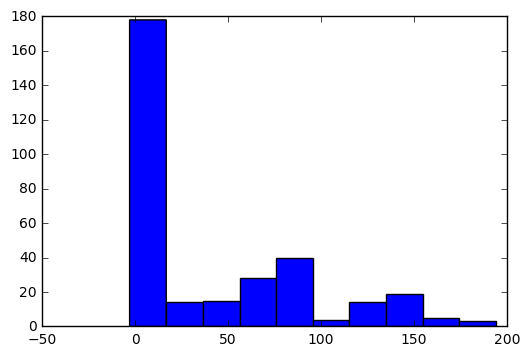

In [510]:
columnsToDelete =["actionStrength","timeEffect","TimeWeight"]
user_df = user_df.drop((column for column in user_df.keys() if column in columnsToDelete),axis=1)
combinedDF= news_df.merge(user_df,how="right",left_on="Article_Id",right_on="Article_Id")
combinedDF["daysSinceRead"] = combinedDF["Date"].apply(timePassed)

# we consider that an eligible user can read 10 words in a minute. we can use this information to generate oure expected time spent
avgWordSpeed =110

combinedDF["expectedTimeSpent"] = round((combinedDF["storylength"]/avgWordSpeed)*60)
import seaborn as sns
combinedDF["TimeSpent"].describe()
from matplotlib import pyplot as plt
%matplotlib inline
plt.hist(combinedDF["TimeSpent"])

(array([58., 56., 89., 64., 27.,  9.,  9.,  4.,  1.,  3.]),
 array([  5. ,  62.3, 119.6, 176.9, 234.2, 291.5, 348.8, 406.1, 463.4,
        520.7, 578. ]),
 <a list of 10 Patch objects>)

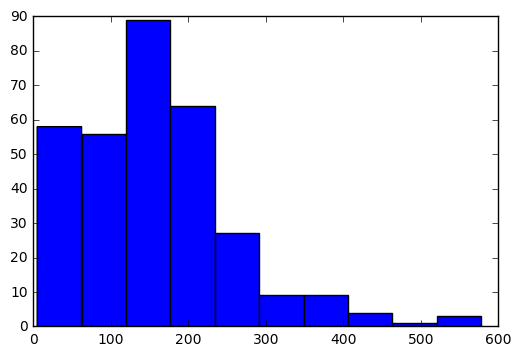

In [511]:
# If we exclude Articles which were not clicked ,we see majority of user's spent time less than 100 and in upper range , majority of user's spent 150 seconds
# one thing to  note is this the approximated data which we have generated. We are analyzing it for the sake of understanding
plt.hist(combinedDF["expectedTimeSpent"])

In [32]:
# the above graph shows the expected time spent which is way different from our approximation. we may have to rethink our mixture models as stories are pretty big.

In [512]:
# user interest on a particular story can be grouped using below bins
# Low/Not interested -  Less than 15
# Average -  anywhere between 15-35
# Good - above 35
# We give story a weightage if user has clicked on i, atleast he was interested in title
clickedMapping = {"Yes":2,"No":0}
combinedDF["ClickStrength"] = combinedDF.Click.map(clickedMapping)

#Replacing missing values in timespent column by 0
combinedDF.TimeSpent.fillna(0,inplace=True)

#creating a category field for TimeSpent variable to better take the effect
combinedDF["IntCategory"] = pd.cut(combinedDF.TimeSpent,bins=[0,15,35,40,1000],include_lowest=True,labels=["Not Seen","NI","Moderate","Intrested"])
#Assigning weights for the timeSpent
TimeSpentMapping = {"Not Seen":0,"NI":1,"Moderate":2,"Intrested":4}
combinedDF["IntWeight"] = combinedDF["IntCategory"].map(TimeSpentMapping)
combinedDF["timeRatio"] = (combinedDF["expectedTimeSpent"]/combinedDF["TimeSpent"])
combinedDF["timeRatio"] = combinedDF["timeRatio"].astype(int)
# Add the weights 
combinedDF["CombinedWeight"]=combinedDF["IntWeight"]+combinedDF["ClickStrength"]

In [513]:
# We will create a new view of the data with these parameters
# recent news
#most Popular news
# create user representation in terms of Topics

# To create the User Profile, We will use articles with which user has shown grater interest
UsersList = np.array(user_df["UserID"].unique())

# let's create  seperate dataframes for seperate users to generate the user profiles
dfDict={}
for i in range(len(UsersList)):
    tempDf = combinedDF.query("UserID=="+str(UsersList[i]))
    dfDict[str(UsersList[i])] = tempDf

In [514]:
# now we have seperate dataframe for seperate users, we can start working on user profile part
# get userDF say for 1st User, this will become the entry point for our recommendation engine, where we will provide recommendation for the given user id
UserDF = dfDict[str(1)]

In [515]:
# We will sort all the Articles which were presented to user according to two below criterias and take top 10 weighted articles.
#1 - Recentness- It was read how many days ago .
#2 - CombinedWeight - the interaction user did with it. e.g. Click, timespent weight we calculated earlier.
UserDF = UserDF.sort_values(["daysSinceRead","CombinedWeight"],ascending=[True,False]).head(10)

In [516]:
# the idea behind getting these articles is that since these are most recent/liked items, these represent user's latest preference and we can get
# the user profile if we find the cenetroide probability distribution for our user.
# I said probability distribution becase we already have Probability distribution for all the articles and we can fetch the prob dist for our top 10 articles.
UserArticles = UserDF.Article_Id
UserTopRep = TopicToDocMat[UserArticles]
# we have six topics so we will have six column in our matrix, we will create mean for each topic  and combine these to create user topic probability distribution.
mean_1st = np.mean(UserTopRep[:,0])
mean_2nd = np.mean(UserTopRep[:,1])
mean_3rd = np.mean(UserTopRep[:,2])
mean_4th = np.mean(UserTopRep[:,3])
mean_5th = np.mean(UserTopRep[:,4])
mean_6th = np.mean(UserTopRep[:,5])
UserCent = np.array([mean_1st,mean_2nd,mean_3rd,mean_4th,mean_5th,mean_6th])

In [517]:
# now we have our average user profile for user 1 and  we can see that user 1 doesn't like some specific kind of news. user likes articles which have high probability distributionn
# for topic 2,3,4,5. we can cross check the same

In [518]:
# creating the average profile for all the remaining users.
def createUserProfile(userId):
    UserDF = dfDict[str(userId)]
    UserDF = UserDF.sort_values(["daysSinceRead","CombinedWeight"],ascending=[True,False]).head(10)
    UserArticles = UserDF.Article_Id
    UserTopRep = TopicToDocMat[UserArticles]
    mean_1st = np.mean(UserTopRep[:,0])
    mean_2nd = np.mean(UserTopRep[:,1])
    mean_3rd = np.mean(UserTopRep[:,2])
    mean_4th = np.mean(UserTopRep[:,3])
    mean_5th = np.mean(UserTopRep[:,4])
    mean_6th = np.mean(UserTopRep[:,5])
    UserCentProfile = np.array([mean_1st,mean_2nd,mean_3rd,mean_4th,mean_5th,mean_6th])
    return UserCentProfile
# create UserCentroide dataframe 
userProf = pd.DataFrame()
for k in dfDict.keys():
    UserCent = createUserProfile(k)
    userProf = userProf.append(pd.DataFrame(UserCent.reshape(1,6)),ignore_index=True)
    
userProf["id"] =list(dfDict.keys())

# idea is that if we create clusters, we would get similar users in similar clusters and we will not have to count similarity b/w
# all the user's to get matching /neighbor User

from sklearn.cluster import KMeans
newuserProf = userProf.copy()
# droping user id as it is just ID and including it in kmeans will be misleading
newuserProf.drop("id",axis=1,inplace=True)
# Number of clusters
kmeans = KMeans(n_clusters=3)
# Fitting the input data
kmeans = kmeans.fit(newuserProf)
# Getting the cluster labels
labels = kmeans.predict(newuserProf)
labels =labels+1
userProf["Category"] = labels  


In [387]:
# recommendation part
# now we have come to the part where we will generate recommendations for our users.
#We will use a slightly different approach to get recommendations. Below is the descriptions.
# We have converted the articles into respective probability distribution for our six topics . Now instead of categorizing the articles and selecting from a 
# category , we will select articles which are more similar to user's own Probability distribution for given 6 topics.
# since we have to give 10 recommendations, we will give 5 according to user, 3 according similar/Neighbor users and 2 which are most popular/trending.

# ColdStart Problem
# For a new user user, we may not have any articles to create user centroide and our existing framework will fail. This is known as cold start problem in recommendation space 
# where we do not know what a user will like. there are several methods to deal with it and all have their strengths and weeknesses.
# Here we are assuming that since our users are also represented as Topic probability distribution, we might be able to create a generic profile for 
# a new user by finding an average user centroide from all available users. Since we have approximated our data randomly , we will assume this process
# is fair and can be used till the time user's own frofile becomes available

In [522]:
#now we have user profiles represented as centroides of topics, we will find news articles more similar to user using cosine similarity
# and will display them using a randomly generated rank vars
# we will remove the articles already liked and viewed by user to get future recommendations.
try:
    UserId = int(input())
    if UserId<1 or UserId>userProf.shape[0]:
        top10Art = GetNewUserRecommendations(TopicToDocMat)
        print ("You seems to be new to our site..")
        print ("These are some good reads liked by our users - ",top10Art)
    else:
        UserRecommendations =getRecommendationsExistingUser(UserId)
        print("Top Recommendations for user",UserRecommendations)
except:
    print("please enter a numeric ID")


33
You seems to be new to our site..
These are some good reads liked by our users -  [3744, 2791, 2861, 2841, 2917, 2939, 4660, 2742, 2747, 2746]


In [490]:

def GetRemainingRecommendations(UserRecommendations,combinedDF,ID,remaingItems):
    combinedDFNew = combinedDF.copy()
    
    UserDF = dfDict[str(ID)]
    ArticleToExclude = list(UserDF.Article_Id)
    ArticleToExclude.extend(UserRecommendations)
   
    RemaingDF = combinedDFNew[~combinedDFNew["Article_Id"].isin(ArticleToExclude)].copy()
    RemaingDF =RemaingDF.sort_values(["CombinedWeight"],ascending=[False]).head(remaingItems)
    ArticleToInclude = list(RemaingDF.Article_Id)
    UserRecommendations.extend(ArticleToInclude)
    return UserRecommendations

def GetUserRecommendations(ID):
    UserDF = dfDict[str(ID)]
    ArticleToExclude = UserDF.Article_Id
    RemaingDF = news_df[~news_df["Article_Id"].isin(ArticleToExclude)].copy()
    #Now we also need to get the Portion of TopicToDoc matrix which was not related to our user
    # since TopicToDocMat matrix is organised according to Article ids as these are also starting from 1
    RemTopicToDoCMat = TopicToDocMat[RemaingDF.Article_Id]
    # get user centraoide
    usercent = np.array(userProf.loc[userProf["id"]==str(ID),[0,1,2,3,4,5]]).reshape(1,6)
    #Now we can create  a similarity matrix to find similar movies according to TopicUserMatrix
    UserMergedMatrix = np.concatenate([usercent,RemTopicToDoCMat])
    from sklearn.metrics.pairwise import linear_kernel
    cosSimilarity = linear_kernel(UserMergedMatrix,UserMergedMatrix)
    # get 5 most similar articles
    top5Art = list(cosSimilarity[1].argsort()[:-6:-1])
    return top5Art

def getSimilarUser(UserId):
    #to get similar users from given user
    userCat = userProf.loc[(userProf["id"]==str(UserId)),"Category"].copy()
    userCat =  userCat.tolist()
    userCat[0]
    userOfCat = userProf.loc[userProf["Category"]==userCat,["id"]].copy()
    userOfCat= userOfCat.loc[~(userOfCat["id"]==str(UserId)),["id"]].copy()
    userOfCat = list(userOfCat.id)
    return userOfCat

def getCollabRecommendation(userOfCat):
    Collablist =[]
    for u in userOfCat:
        UserRecs = GetUserRecommendations(u)
        Collablist.extend(UserRecs)
    return Collablist

def getRecommendationsExistingUser(UserId):
    
    UserRecommendations = GetUserRecommendations(UserId)
    SimilarUser = getSimilarUser(UserId)
    # Getting articles fro these users to provide collaborative recommendations
    # here we are getting recommendations for these neighbors, we could fetch top movies rated byt these users as well
    Collablist =getCollabRecommendation(userOfCat)

    # create logic For 10 recommendations
    TotalRec =10
    AvlRec =len(UserRecommendations)
    NeededRecs = TotalRec-AvlRec
    # Getting remaining Recs from CollabList using random sampling and removing duplicates

    UniqueRecs = list(set(Collablist).difference(UserRecommendations))
    if len(UniqueRecs)==0:
        UserRecommendations =UserRecommendations

    elif len(UniqueRecs)>=5:

        renRecs = list(np.random.choice(UniqueRecs,5,replace=False))
        UserRecommendations.extend(renRecs) 
    else:
        renRecs = list(np.random.choice(UniqueRecs,len(UniqueRecs),replace=False))
        UserRecommendations.extend(renRecs)

    # Now check if total recommendations are less than 10. If yes, random remaining randomly based on the basis of popularity 
    AvlRec =len(UserRecommendations)
    NeededRecs = TotalRec-AvlRec
    
    if NeededRecs>0:
        UserRecommendations = GetRemainingRecommendations(UserRecommendations,combinedDF,UserId,NeededRecs)
    UserRecommendations = list(np.random.choice(UserRecommendations,len(UserRecommendations),replace=False))
    return UserRecommendations

# creating the average profile for new user from  the available users.
def createAverageUserProfile(userProf):
    UserDF = userProf.copy()
    UserDF.drop(["id","Category"],axis=1,inplace=True)
    UserDF =np.array(UserDF)
    mean_1st = np.mean(UserDF[:,0])
    mean_2nd = np.mean(UserDF[:,1])
    mean_3rd = np.mean(UserDF[:,2])
    mean_4th = np.mean(UserDF[:,3])
    mean_5th = np.mean(UserDF[:,4])
    mean_6th = np.mean(UserDF[:,5])
    UserCentProfile = np.array([mean_1st,mean_2nd,mean_3rd,mean_4th,mean_5th,mean_6th])
    return UserCentProfile

def GetNewUserRecommendations(TopicToDocMat):
    AvgUserCent = createAverageUserProfile(userProf)
    RemTopicToDoCMat = TopicToDocMat
    # get user centraoide
    usercent = AvgUserCent.reshape(1,6)
    #Now we can create  a similarity matrix to find similar movies according to TopicUserMatrix
    UserMergedMatrix = np.concatenate([usercent,RemTopicToDoCMat])
    from sklearn.metrics.pairwise import linear_kernel
    cosSimilarity = linear_kernel(UserMergedMatrix,UserMergedMatrix)
    # get 5 most similar articles
    top10Art = list(cosSimilarity[1].argsort()[:-11:-1])
    return top10Art




In [397]:
# Now when we have found matching recommendation for user, we will focus on  recommendations from other similar users
# I will try using DBScan to find siilar users.the basis is that I don't need to provide number of clustes and I don't want to use cosine similarity.
# DB scan has many advantages and disadvantages.
# advantages -  we don't need to provide number of clusters
#               It can find arbritrary shapes
#               It is very fast
# DisAdvantage -It is very sensitive to parameters you choose to initialize such as min_sample and epsilon

# The summary of this algorithm is:
# Step 1: For each point in the dataset, we draw a n-dimensional sphere of radius epsilon around the point (if you have n-dimensional data).
# Step 2: If the number of points inside the sphere is larger than min_samples, we set the center of the sphere as a cluster, and all the points within the sphere are belong to this cluster.
# Step 3: Loop through all the points within the sphere with the above 2 steps, and expand the cluster whenever it satisfy the 2 rules.
# Step 4: For the points not belong to any cluster, you can ignore them, or treat them as outliers. 
# from sklearn.cluster import DBSCAN

# epsilon = .01

# # Run the DBSCAN from sklearn
# db = DBSCAN(eps=epsilon, min_samples=2).fit(newuserProf)
# #labels = db.labels_
